# Projet numérique : lignes de niveau (Nathan Weill, Gaspard Brue)

Calcul des lignes de niveau d'une fonction de deux variables réelles et à valeurs réelles, i.e. les ensembles de la forme 
$$\{(x,y)\in \mathbb{R^2} \lvert f(x,y)=c \}$$

## Plusieurs idées : 

* On fixe une variable (x par exemple, en partant de x = 0) et on résout une équation pour une fonction de une variable par dichotomie ; on itère ce procédé en incrémentant x de delta à chaque itération :$$f(n\delta,y_{n}) - c = 0$$ Cette méthode est naïve et peu précise car on ne prend pas en compte la direction et le sens de la ligne de niveau.

* On pense alors au gradient. En effet, il est orthogonal aux lignes de niveau : soit $$\gamma(t)=(x(t),y(t)), \forall t, f(\gamma(t))=c$$ en dérivant par rapport à t, il vient : $$\nabla f(\gamma(t))\cdot\gamma'(t)=0$$
On construit alors une suite de points ainsi : le premier point est obtenu comme dans la première méthode en fixant x=0. Puis on fait : $$\left( \begin{array}{c} x_{k+1} \\ y_{k+1}  \end{array} \right)=\left( \begin{array}{c} x_{k} \\ y_{k}  \end{array} \right)+ \delta*n$$ où $$n=\nabla f^\bot / \lVert \nabla f^\bot \rVert$$
On prend soin de rester dans le carré qui nous intéresse, c'est-à-dire que nous suivons la ligne de niveau dans le bon sens en testant sur la première itération s'il faut ajouter ou retrancher n. C'est la méthode que nous utilisons dans ce projet en utilisant $$\left( \begin{array}{c} a \\ b  \end{array} \right)^\bot = \left( \begin{array}{c} -b \\ a  \end{array} \right)$$

* Le problème de cette méthode est la propagation d'erreurs due à l'approximation d'un fragment de ligne de niveau par une portion de droite en supposant le découpage et delta assez petits 


### Échecs et problèmes rencontrés

Sans normer le gradient et en prenant n'importe quel sens, la propagation d'erreurs était trop importante et l'on obtenait une spirale au lieu d'un cercle

## Code

In [59]:
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
from math import *


In [60]:
def find_seed(g, c=0, eps=2**(-26)):
    # dichotomie de g(t) fonction de une variale
    a,b=0,1
    if (g(a)-c)*(g(b)-c)>0:
        return None
    while (b-a)/2 >= eps:
        
        t=a+b/2
        if (g(a)-c)*(g(b)-c)<=0:
            b=t
        else:
            a=t
        
    return (a+b/2)

In [61]:
def simple_contour(f, c=0.0, delta=0.01):    #méthode 2 pésentée ci-dessus
    def grad_f(x,y):
        g=autograd.grad
        return np.r_[g(f,0)(x,y), g(f,1)(x,y)]
    
    if find_seed(lambda t : f(0.,t)) != None :
        x,y = 0.,find_seed(lambda t : f(0.,t))
    else : 
        return [[-1],[-1]]
    
    
    n = [-grad_f(x,y)[1], grad_f(x,y)[0]]
    norme = np.sqrt(n[0]**2 + n[1]**2)
    X=[x]
    Y=[y]
    s = 0
    x,y = x - delta/norme*grad_f(x,y)[1],y + delta/norme*grad_f(x,y)[0]
    if 0<=x<=1 and 0<=y<=1:
        s = 1
        X.append(x)
        Y.append(y)
    else:
        s = -1
        x,y = 0.,find_seed(lambda t : f(0.,t))
    while 0<=x<=1 and 0<=y<=1:   
        x,y = x - s*delta/norme*grad_f(x,y)[1],y + s*delta/norme*grad_f(x,y)[0]
        X.append(x)
        Y.append(y)
    return X,Y

In [62]:
def h(x,y): 
    """essai de simple_contour qui doit donner un arc de cercle"""
    return x**2 + y**2 - 0.5


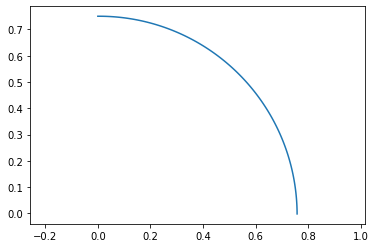

In [63]:
plt.plot(simple_contour(h, 1.0)[0],simple_contour(h, 1.0)[1])
plt.axis('equal')
plt.show()

_On obtient un arc de cercle comme voulu_

In [64]:
def f(x,y):
    return np.exp(-x**2 - y**2)

def g(x,y):
    return np.exp(-(x-1)**2 - (y-1)**2)

def j(x,y):
    return 2*(f(x,y) - g(x,y))

In [65]:
LEFT, UP, RIGHT, DOWN = 0, 1, 2, 3  # clockwise


def rotate_direction(direction, n=1):
    return (direction + n) % 4


In [66]:
def rotate(x, y, n=1):
    if n == 0:
        return x, y
    elif n >= 1:
        return rotate(1 - y, x, n - 1)
    else:
        assert n < 0
        return rotate(x, y, n=-3 * n)


def rotate_function(f, n=1):
    def rotated_function(x, y):
        xr, yr = rotate(x, y, -n)
        return f(xr, yr)

    return rotated_function

In [67]:
def contour(f, c, xs=[0.0, 1.0], ys=[0.0, 1.0], delta=0.01):
    curves = []
    nx, ny = len(xs), len(ys)
    for i in range(nx - 1):
        for j in range(ny - 1):
            xmin, xmax = xs[i], xs[i + 1]
            ymin, ymax = ys[j], ys[j + 1]

            def f_cell(x, y):
                return f(xmin + (xmax - xmin) * x, ymin + (ymax - ymin) * y)

            done = set()
            for n in [0, 1, 2, 3]:
                if n not in done:
                    rotated_f_cell = rotate_function(f_cell, n)
                    x_curve_r, y_curve_r = simple_contour(rotated_f_cell, c, delta)
                    exit = None
                    if len(x_curve_r) >= 1:
                        xf, yf = x_curve_r[-1], y_curve_r[-1]
                        if xf == 0.0:
                            exit = LEFT
                        elif xf == 1.0:
                            exit = RIGHT
                        elif yf == 0.0:
                            exit = DOWN
                        elif yf == 1.0:
                            exit = UP
                    if exit is not None:  # a fully successful contour fragment
                        exit = rotate_direction(exit, n)
                        done.add(exit)

                    x_curve, y_curve = [], []
                    for x_r, y_r in zip(x_curve_r, y_curve_r):
                        x, y = rotate(x_r, y_r, n=-n)
                        x_curve.append(x)
                        y_curve.append(y)
                    x_curve = np.array(x_curve)
                    y_curve = np.array(y_curve)
                    curves.append(
                        (xmin + (xmax - xmin) * x_curve, ymin + (ymax - ymin) * y_curve)
                    )
    return curves

In [68]:
xs = [-2.0, -1.0, 0.0, 1.0, 2.0, 3.0]
ys = [-1.0, 0.0, 1.0, 2.0]
c = 0.5

level_curves = contour(j, c, xs, ys) 

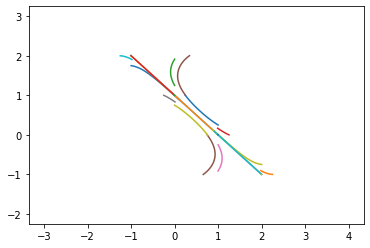

In [70]:
for x, y in level_curves:
    plt.plot(x, y)